# Augmented recipe recommendation using flavor profile, ingredients, and cooking technique

### Micaela McCall

## Background and Literature Review

As the amount of information on the internet has ballooned, recommendation systems have become increasingly crucial to help users
find desired information without having to do extensive manual search. For a while I have been curious about how these systems work given the extensive way they touch my daily life. I decided to explore various approaches to recommendation algorithms in the domain of food and recipes, which is particularly relevant given the vast number of online recipes. 

The goal of a recommender system is to predict the rating a user would give to a new item and to suggest to the user items for which the predicted rating is high. Several common approaches are: 

**Collaborative filtering (CF)** is a method that uses the ratings of many users over many items to identify similar users and predict the rating a user would give to an item based on the ratings given by similar users. The only data necessary for this approach is ratings history on items \[5\].

**Content-based (CB)** is a method that uses information about items to calculate similarity between new items and items a user has historically
rated to predict the rating a user would give to an item \[1\]. 

**Hybrid approaches** aim to combine the strengths of multiple previously mentioned approaches.  This can be done in many ways, such as averaging results of CF and CB predictions, using the prediction from one approach as the input to another, and introducing more advanaced optimization techniques to apply elements from both CB and CF appraoches in one algorithm. \[1, 7\]


# Project Goals

I aimed to explore and compare the performance of CB, CF, and hybrid recommender algorithms in the context of recipe recommendation, while leveraging recipe flavor profiles and recipe metadata (meal type, cooking technique, cooking time) in the recommendation.

# Data Sources

The first data set is a set of recipes from Food.com, made available on
as a Kaggle dataset
(<https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?resource=download&select=RAW_recipes.csv>).
The recipes data includes the name of the recipe, a description of the
recipe, recipe tags, the nutritional value, the steps in make the
recipe, and the ingredients.\
The second data set is a set of recipe interactions also from Food.com
and also made available through Kaggle
(<https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?resource=download&select=RAW_interactions.csv>).
This data set includes the rating and review given to a recipe by
various users (recipe id matches up to the recipe id in the recipes data
set above).\
The third data set provides the flavor molecules and associated flavor
profile for a given food (from
<https://cosylab.iiitd.edu.in/flavordb/>). It is accessed via API calls
for each ingredient in the recipes from the first datset.\
A final data set provides ingredient lemmatization, or in orther words
associating each possible ingredient with a \"base\" version of that
ingredient (e.g. all types of lettuce become \"lettuce\"). Also made
available through Kaggle
(<https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions/discussion/118716?resource=download&select=ingr_map.pkl>).


# Algorithm Details 

For this project I coded each of the following algorithms from scratch using numpy and Pytorch, among other packages.

**Collaborative filtering (CF)**

**Nearest neighbors:** calculate the nearest neighbors of a new user
measured by cosine similarity:
$$Sim(u_i, u_k) := \frac{r_i * r_k}{||r_i||*||r_k||} = \frac{\sum_{j=1}^mr_{ij}r_{kj}}{\sqrt{\sum_{j=1}^mr_{ij}^2\sum_{j=1}^mr_{kj}^2}}$$
where $r_i$ and $r_k$ are ratings vectors for users $u_i$ and $u_k$.

Predict a user's rating on a new recipe $r_{ij}$ by weighted average
with bias avoided by by subtracting each user's average rating
$\tilde{r_k}$ from their rating of the recipe and adding in the target
user's average rating $\tilde{r_i}$:
$$r_{ij} = \tilde{r_i}+\frac{\sum_kSim(u_i, u_k)(r_{kj}-\tilde{r}_k)}{\text{num ratings}}$$

**Matrix Factorization:** aims to decompose the user's preferences for
into preferences for a set of latent factors. Matrix factorization can
be performed using Singular Value Decomposition (SVD):
$$M = U\Sigma V^T$$ 
By selecting the top $k$ singular values of matrix
$\Sigma$, we can reconstruct matrix $M$ with less dimensions but still
capturing much of the variability of the original matrix \[9\]. The
concept here, when applied over recipe ratings, would be to find the
dimensions of latent food preferences so as to avoid having to deal with
the high dimensionality of individual recipe ratings.

However, when factoring a sparse matrix, it's more efficient to use
Non-negative Matrix Factorization (NMF), which involves finding $P$ and
$Q$ such that the reconstructed user-item rating
$\hat{r}_{ui}= q_i^Tp_u$ is as close as possible to the true ${r}_{ui}$.
In order to find $P$ and $Q$, the Mean Squared Error is minimized:

$$min_{q,p} \sum_{(u, i) \in TR} (r_{ui} - q_i^Tp_u)^2 + \lambda(||q_i||^2+||p_u||^2)$$
where $p_u$ is the user vector, the $u$-th row of matrix $P$, and $q_i$
is the item vector, the $i$-th row of matrix $Q$, and $TR$ is the
training set \[9\]. I implemented this optimization by hand by
performing Gradient Decent according to the implementation in Luo et al.
(2014). On each update of the Gradient Decent, the entries of the $P$
and $Q$ matrices are updated as below:

$$p_{u,k} \leftarrow p_{u,k}\frac{\sum_{i \in TR}q_{k,i} r_{u,i}}{|I_u|\lambda p_{u,k} + \sum_{i \in TR} \hat r_{u,i}}$$

$$q_{k,i} \leftarrow q_{k,i}\frac{\sum_{i \in TR}p_{u,k} r_{u,i}}{|U_i|\lambda q_{k,i} + \sum_{i \in TR} \hat r_{u,i}}$$
where $I_u$ is the number of ratings for that user in the item set, and
$U_i$ is the number of rating for that item in the user set. A
prediction for a new user-recipe pair is simply the $\hat r_{ui}$ entry
in the reconstructed $\hat R = PQ^T$ matrix.\
**Content-based (CB)**

A rating for each user on each ingredient is calculated as the average
of the ratings each user gave to all recipes including that ingredient:
$$rat(u_i, ingr_j) = \frac{\sum_{l; ingr_j \in l}r_{il}}{l}$$ 
where
$r_{il}$ is the rating user $i$ gave to recipe $l$. This formula is then
applied over the flavor profile of each recipe, tags, and cooking
techniques, to create a comprehensive recipe-based data source for each
user. Predict a user's rating on a new recipe $r_{ij}$ by finding the
average rating across all the ingredients, flavors, and cooking
techniques in the new recipe:

$$r_{ij} = \frac{\sum_{l\in rec_j} rat(u_i, ingr_l)}{l}$$

**Hybrid**

**Content-augmented CF using cosine similarity**: attempts to generate
as many ratings as possible for a user on ingredients, flavors, and
techniques using ratings given by similar users, and then uses an
average of the ratings of the content of a recipe to predict a new
user-recipe rating.\
To be more specific, this involved three steps:

**1.** I used Equation 1 to find the nearest neighbors of a new user (as
in the CF approach).

**2.** Then, I used the following equation to predict a new user's
ratings on ingredients, flavors, and techniques that they hadn't already
rated:

$$rat(u_i, ingr_d) = \frac{\sum_k Sim(u_i, u_k)rat(u_k, ingr_d)}{\text{num ratings of }d}$$

**3.** Then I used Equation 8 to predict a user's rating on a new recipe
$r_{ij}$.

**Content-augmented matrix factorization**: takes the matrix
factorization approach to CF and augments the item data with content. I
used NMF for this approach, like the basic matrix factorization
approach. However, I incorporated recipe content information into this
factorization by further factoring the matrix $Q$ (shape: num features
by num recipes) as $X\Phi$, where $X$ is a matrix (shape: num recipes by
num ingredients) in which $X_{id}$ is a binary indicator if ingredient
$d$ is in recipe $i$. This results in the following NMF factorization of
matrix $R$: $$R = P\Phi^TX^T$$ My source for this approach is Forbes et
al. (2011). This updated NMF results in the following minimization of
MSE: $$min_{\phi,p} \sum_{(u,i) \in TR} (r_{ui} - p_u\Phi^Tx_i^T)^2$$

Rather than implementing the updates to each matrix on each iteration of
Gradient Descent by hand like I did for the basic matrix factorization,
I decided to use Pytorch to calculate and update the matrices according
to MSE loss. Once training is complete, a prediction for a new
user-recipe pair is simply the $\hat r_{ui}$ entry in the reconstructed
$\hat R = P\Phi^TX^T$ matrix.


---

## Data Preprocessing
### Recipe Ingredients
I started by processing the ingredient map that was part of the Kaggle data. I created a unified list of ingredients for all recipes in the following way: for each recipe, I applied a SpaCy model to a string representation of its ingredients and only the noun and proper nouns were preserved, and then all noun and proper nouns were given a unique id and added to a de-duplicated list. The reason for this pre-processing step is that each word in the list was queried in the FlavorDB API, and it wouldn't do to query a modifier (e.g. "fresh\" in the ingredient "fresh strawberries\").


In [40]:
import pandas as pd
pd.options.mode.chained_assignment = None
import spacy
nlp = spacy.load("en_core_web_sm")

# Import ingredients data
ingr_map = pd.read_pickle("food.com_recipes/ingr_map.pkl")

def nounify_ingredient(ingredient_str):
    # Remove ingredients that aren't nouns or proper nouns
    if len(ingredient_str.split(" ")) == 1:
        return ingredient_str
    else:
        return " ".join([t.text for t in nlp(ingredient_str) if t.pos_ == 'NOUN' or t.pos_ == "PROPN"])

def build_ingredient_dict(ingr_map):
    # Filter by if the count in the data is > 10 
    filt_ingr = ingr_map[ingr_map['count'] > 10][['id', 'replaced']].drop_duplicates()
    # Remove ingredients that aren't nouns or proper nouns
    filt_ingr['ingredients'] = filt_ingr['replaced'].apply(nounify_ingredient)
    ingr_dict = dict(zip(filt_ingr['id'], filt_ingr['ingredients']))
    return ingr_dict


ingr_dict = build_ingredient_dict(ingr_map)
list(ingr_dict.items())[:10]

[(4308, 'lettuce'),
 (6843, 'stuffing mix'),
 (1910, 'cream cheese'),
 (1168, 'cheddar'),
 (5811, 'radicchio'),
 (5205, 'pasta'),
 (7233, 'tomato sauce'),
 (4836, 'mozzarella'),
 (912, 'cake mix'),
 (6330, 'herb')]

## Querying FlavorDB
For each ingredient in this list, I queried the FlavorDB search API to find the most similar search result that exists in their DB. For the search match, the search term was then used in the query for specific flavor molecules, which were subsequently matched with their individualflavors. 

Below is the flavor profile for "lettuce"

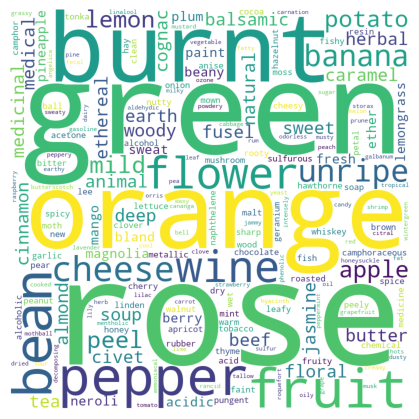

In [3]:
import urllib.request
import json
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ast import literal_eval

def find_flavors(ingredient):
    # For the query, spaces must be & symbols instead
    search_term = ingredient.replace(" ", "&")
    # Initiate list of flavors
    flavors = []
    # Create search url for ingredient to get back it's id
    bu = f"https://cosylab.iiitd.edu.in/flavordb/entities?entity={search_term}&category="
    with urllib.request.urlopen(bu) as url:
        b = json.loads(json.loads(url.read().decode()))
        # find the result that has the ingredient
        b = list(filter(lambda x: x['entity_alias_readable'].lower() in ingredient, b))
        # if nothing is returned, end func
        if len(b) == 0:
            return []
        print(f"found ingredient: {b[0]['entity_alias_readable']}")
    flavdb_id = b[0]['entity_id']
    # Create search url for ingredient to get back flavor molecules
    bu = f"https://cosylab.iiitd.edu.in/flavordb/entities_json?id={flavdb_id}"
    with urllib.request.urlopen(bu) as url:
        a = json.loads(url.read().decode())
    for mol in a['molecules']:
        flavors.extend(mol['fooddb_flavor_profile'].split("@"))
    # Return a list of all flavors
    return list(set(flavors))[1:]

with open('data/ing_flav_dict.txt', 'r') as f:
    ing_flav_dict = json.load(f)


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(ing_flav_dict['lettuce']))

plt.figure(figsize = (8, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Merging Flavor and Ingredients
I merged each recipe id with its constituent ingredients and each ingredient's corresponding flavors. 

In [27]:
# Import the full recipes dataset and isolate the ingredients in each recipe
pp_ingr = pd.read_csv("food.com_recipes/PP_recipes.csv")[['id', 'ingredient_ids']]
# Change the string of list in this column to a list of strings
pp_ingr['ingredient_ids'] = pp_ingr['ingredient_ids'].apply(json.loads)
def ingr_match_and_filter(ingr_ids):
    # Given that the recipes data only has ingredient ids, we want to match those ids to the ingredient string
    try:
        ingr_list = [ingr_dict[i] for i in ingr_ids]
    except KeyError:
        ingr_list = None
    return ingr_list

pp_ingr['ingredients'] = pp_ingr['ingredient_ids'].apply(ingr_match_and_filter)

def flav_match(ingredients):
    # Use the ing flav dict constructed before to select the flavors for each ingredient in a recipe
    flav_list = []
    for i in ingredients:
        try:
            flav_list_i = ing_flav_dict[i]
        except KeyError:
            continue
        if len(flav_list_i) >0:
            flav_list.extend(flav_list_i)
    # De-duplicate
    flav_list = list(set(flav_list))
    return flav_list

def literal_return(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val


pp_ingr = pp_ingr[pp_ingr['ingredient_ids'].isna() == False]
pp_ingr['ingredients'] = pp_ingr['ingredient_ids'].apply(ingr_match_and_filter)
pp_ingr = pp_ingr[pp_ingr['ingredients'].isna() == False]
pp_ingr['flavors'] = pp_ingr['ingredients'].apply(flav_match)
pp_ingr = pp_ingr.rename(columns={'id':'recipe_id'})
pp_ingr[:10]

,recipe_id,ingredient_ids,ingredients,flavors
0,424415,"[389, 7655, 6270, 1527, 3406]","[basmati rice, water, salt, cinnamon stick, gr...","[sassafrass, wax, fat, grass, spice, maple, gr..."
1,146223,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,...","[flmy, oat, sugar, pecan, butter, egg, pack pu...","[watery, grass, citrus peel, soy, galbanum, fe..."
2,312329,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696...","[chicken broth, water, salt, pepper, onion pow...","[grass, citrus peel, soy, galbanum, styrene, s..."
3,74301,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]","[wonton wrapper, hamburger, taco, salsa, chees...","[yeast, watery, fat, peanut butter, wax, hop_o..."
4,76272,"[3484, 6324, 7594, 243]","[ground beef, sausage, velveeta cheese, ature ...","[cheese, very mild, cheesy, bitter, grassy, so..."
7,186383,"[2683, 4969, 332, 335, 6270, 800, 4987, 7470, ...","[flmy, oat, powder, soda, salt, sugar, oil, va...","[wax, fat, horseradish, grass, spice, cranberr..."
8,116395,"[2683, 1689, 5687, 1098, 840, 7782, 7011, 1910...","[flmy, confectioners sugar, milk, cashew, butt...","[watery, grass, citrus peel, soy, styrene, coc..."
11,331329,"[2300, 1257, 5010, 3203, 1504, 5006, 6272, 7213]","[lentil, chicken broth, onion, garlic clove, v...","[grass, citrus peel, soy, cocoa, seaweed, fenn..."
12,330169,"[912, 2499, 4717, 5093, 7557, 4611, 163]","[cake mix, egg, milk, orange juice, vegetable ...","[watery, unripe plum, grass, citrus peel, soy,..."
13,289290,"[1252, 6711, 3184, 5006, 7655, 6270, 6715]","[chicken breast, spaghetti, garlic, olive oil,...","[grass, citrus peel, soy, cocoa, crushed bug, ..."


Below, as an example of the flavors, I plot 50 randomly chosen flavors and their counts across the recipes

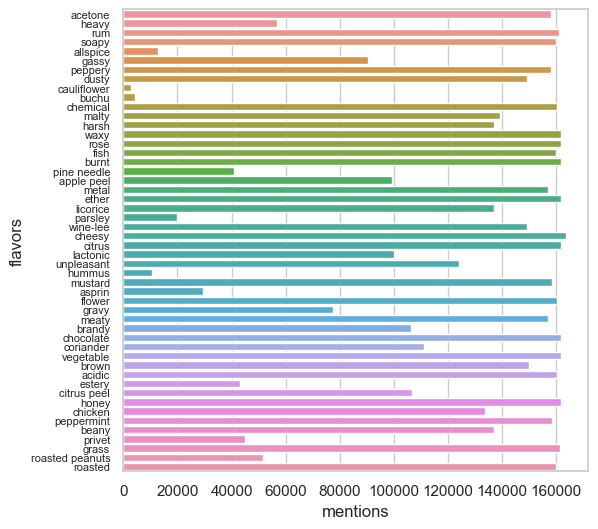

In [44]:
pp_ingr['flavors'] = pp_ingr['flavors'].apply(literal_return)
# Make each flavor it's own row and aggregate by the number of mentions
flav_explode = pp_ingr.explode('flavors')
flav_explode = flav_explode.groupby("flavors").agg(mentions = ('recipe_id', 'count')).reset_index()
# Plot 50 random flavors and their counts across the recipes
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("pastel")
sns.barplot(x="mentions", y="flavors", data=flav_explode.sort_values(by='mentions').sample(50),
            label="Total mentions")
plt.yticks(fontsize=8)
sns.set_color_codes("muted")


## Merging Cooking Techniques
Next, I associated with the technique ids included with each reciipe. 

In [31]:
pp_recipes = pd.read_csv("food.com_recipes/PP_recipes.csv")
with open("data/techniques.txt", 'r') as f:
    techniques = [line.strip() for line in f]

# Associate each yes/no indication in the techniques column with 
# a technique in the techniques list, and add the technique to the recipe if it is associated with a 1
pp_recipes = pp_recipes.rename(columns={'techniques':'technique_onehot'})
pp_recipes['techniques'] = pp_recipes['technique_onehot'].apply(
    lambda x: [ing for (ing, onehot) in zip(techniques, json.loads(x)) if onehot ==1])
pp_techniques = pp_recipes[['id', 'techniques']]
pp_techniques = pp_techniques.rename(columns={'id': 'recipe_id'})
pp_techniques[:10]

,recipe_id,techniques
0,424415,"[combine, drain, strain]"
1,146223,"[bake, combine, melt, pour, refrigerat, smooth..."
2,312329,"[boil, crush, melt, pour, simmer]"
3,74301,"[bake, drain, simmer]"
4,76272,"[combine, drain, fry]"
5,465171,"[boil, drain, thicken, whip]"
6,163861,"[fry, mash]"
7,186383,"[bake, whisk]"
8,116395,"[bake, blend, combine, pour, smooth]"
9,303460,"[barbecue, marinate, roast]"


## Preprocessing Interactions Data
Now it's time to start working with the user interactions data, the main data source for Collaborative Filtering approaches. First of all, I combined the training the testing set that were given on Kaggle because I wanted to do my own train-test split. Let's start by visualizing the spread of ratings and the number of ratings for each recipe.

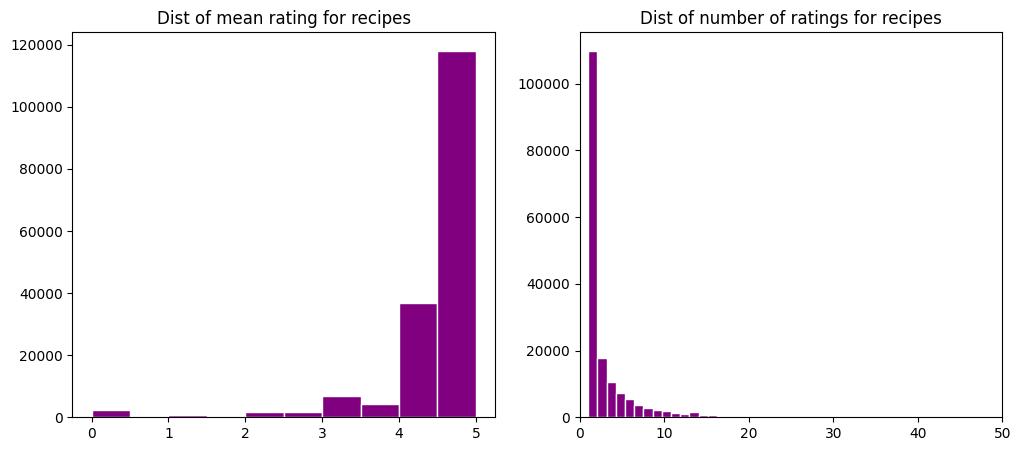

In [32]:
interactions_train = pd.read_csv("food.com_recipes/interactions_train.csv")
interactions_test = pd.read_csv("food.com_recipes/interactions_test.csv")
interactions = pd.concat([interactions_train, interactions_test])
# Calculate mean rating and number of ratings for each recipe
agg = interactions.groupby(["recipe_id", 'i']).agg(mean_rating = ('rating', 'mean'), number_of_ratings = ('rating', 'count'))
def plot_ratings_dist(agg):
    fig = plt.figure(figsize=(12, 5))
    fig_rows = 1
    fig_columns = 2
    fig.add_subplot(fig_rows, fig_columns, 1)
    plt.hist(agg['mean_rating'], bins=10, ec='white', fc='purple')
    plt.title('Dist of mean rating for recipes')
    fig.add_subplot(fig_rows, fig_columns, 2)
    plt.hist(agg['number_of_ratings'], bins=1000, ec='white', fc='purple')
    plt.xlim(0,50)
    plt.title('Dist of number of ratings for recipes')
    plt.show()

plot_ratings_dist(agg)

## Train-test Split
I performed a train-test split by filtering down the data on whether the recipe had at least 10 ratings and then randomly selecting one rating for each of the remaining recipes to be part of the test set. The idea here was to make sure each recipe was represented in both the train and the test sets. See the sizes of the testing and training sets below:

In [39]:
interactions_train = pd.read_csv("data/interactions_train_mm.csv", index_col=0)
interactions_test = pd.read_csv("data/interactions_test_mm.csv", index_col=0)
print(f"Size of training data: {interactions_train.shape}, size of testing data: {interactions_test.shape}")

Size of training data: (351406, 6), size of testing data: (4161, 6)


## Final Merging of Recipe Details and Interactions
The interactions data were merged with the user interactions data such that the rating for each recipe could also be associated with each detail of that recipe. At this point, each recipe "detail\" was collated and
given a detail id (ingredients, flavors, and techniques). For example, when averaging the rating across all the recipes
that has a particular ingredient, you would get the average rating for
that ingredient across the whole data set.

In [37]:
def add_deets_to_recipe(interactions, techniques, ingredients):
    # Merge interactions with techniques and ingredients
    interactions_w_deets = interactions.merge(techniques, how='left', on='recipe_id').merge(ingredients, how='left', on='recipe_id').drop(columns=['ingredient_ids'])
    # Turn into lists and combine
    interactions_w_deets['ingredients'] = interactions_w_deets['ingredients'].apply(literal_return)
    interactions_w_deets['techniques'] = interactions_w_deets['techniques'].apply(literal_return)
    interactions_w_deets['flavors'] = interactions_w_deets['flavors'].apply(literal_return)
    interactions_w_deets['deets'] = interactions_w_deets['ingredients'] + interactions_w_deets['techniques'] + interactions_w_deets['flavors']
    # Explode deets such that each row is a different detail
    interactions_w_deets = interactions_w_deets.explode('deets')
    return interactions_w_deets

interactions_test_w_deets = pd.read_csv("data/interactions_test_w_deets.csv", index_col=0)
interactions_test_w_deets[interactions_test_w_deets['deets'].isna() == False][:20]

,user_id,recipe_id,deets,rating,u,i
5,252816,445,rhubarb,1,1610,103661
6,252816,445,sugar,1,1610,103661
7,252816,445,shortening,1,1610,103661
8,252816,445,egg,1,1610,103661
9,252816,445,soda,1,1610,103661
10,252816,445,salt,1,1610,103661
11,252816,445,cinnamon,1,1610,103661
12,252816,445,flmy,1,1610,103661
13,252816,445,vanilla,1,1610,103661
14,252816,445,confectioners sugar,1,1610,103661


# Recommendation Algorithms 
Now it's time to start the prediction of ratings of new user-recipe pairs. First, I defined some functions to calculate evaluation metrics and plot the predictions against the true ratings in the test set. While the implementation details of the algorithms vary slightly, the overall idea is that each was trained using the training set and then predictions were made on the user-recipe pairs in the testing set so that the performance of each model could be evaluated. I used Root Mean Square Error (RMSE), Mean Absolute Error (MAE) and coverage (ability to generate predictions) \[6\] to evaluate the performance of each approach. 

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_metrics(results, true_total, model_name):
    RMSE = np.sqrt(mean_squared_error(results['rating'], results['rating_pred']))
    MAE = mean_absolute_error(results['rating'], results['rating_pred'])
    coverage = len(results) / true_total

    print(f"{model_name} : RMSE: {RMSE} MAE: {MAE} Coverage: {coverage}")


def plot_results(results, model_name):
    sns.color_palette("crest")
    g = sns.boxplot(data=results, x='rating', y='rating_pred', palette='crest')
    g.set_title(f"{model_name} Results")
    plt.show()

## 0. Baseline algorithm
The baseline model randomly predicts ratings for user-recipe pairs by sampling from a uniform distribution

BL : RMSE: 2.5341953403748154 MAE: 2.066754265065265 Coverage: 1.0


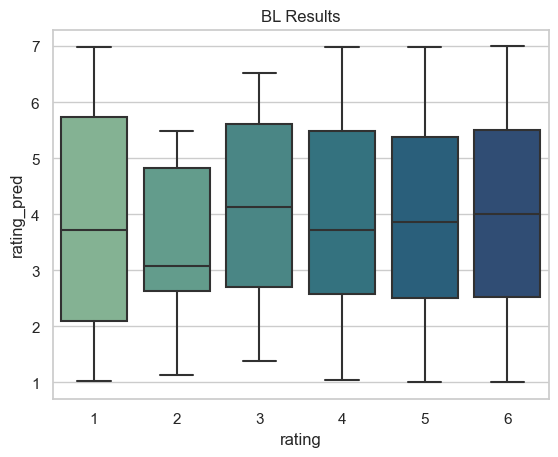

In [45]:
# For future use of sparse matrices, add 1 to all ratings to that the range is 1-6 instead of 0-5
interactions_train['rating'] += 1
interactions_test['rating'] += 1

# Random choice rom a uniform distribution between 1 and 6
rating_pred = np.random.uniform(1, 7, len(interactions_test))

BL = interactions_test[['u', 'i', 'rating']]
BL.loc[:, 'rating_pred'] = rating_pred

# Calculate the true total for the coverage metric
true_total = len(interactions_test[['u', 'i']].drop_duplicates())

# Calculate metrics and plot results of baseline model
calculate_metrics(BL, true_total, "BL")
plot_results(BL, "BL")


## 1. Vanilla Collaborative Filtering

For this model, I compared results for the most similar 10 users, most
similar 50 users, and most similar 100 users.

Below is the code for generting predictions for new user-recipe pairs by averaging the ratings of the most similar 50 users. 

/var/folders/c7/h5ynf4_92p58_gk0jq2jkvl00000gn/T/ipykernel_41287/2934189747.py:8: RuntimeWarning: invalid value encountered in divide
  user_average = np.array(M.sum(axis=1) / np.diff(M.indptr).reshape(-1,1))


CF : RMSE: 0.9805354323601725 MAE: 0.561698932192435 Coverage: 1.0


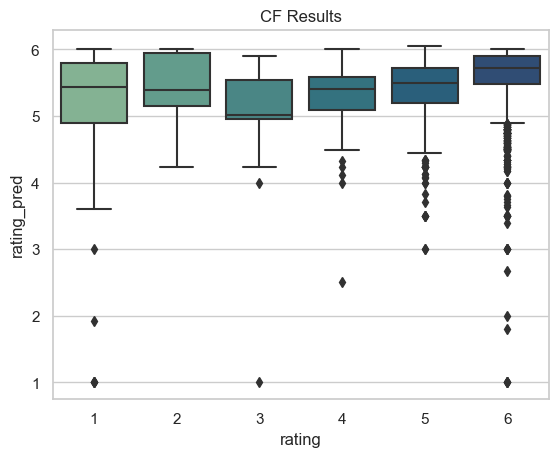

In [46]:
import scipy.sparse as scsp
from sklearn.metrics.pairwise import cosine_similarity

# create user-recipe matrix
M = scsp.csr_matrix((interactions_train['rating'], (interactions_train['u'], interactions_train['i'])))

# Calculate user level rating average
user_average = np.array(M.sum(axis=1) / np.diff(M.indptr).reshape(-1,1))

# Create rating average sparse matrix using the locations of the nonzero elements of interactions matrix
nz = M.nonzero()
user_average = scsp.csr_matrix((user_average[nz[0]].T[0], nz))

# Calculate normalized ratings matrix
M_norm = M - user_average

# Calculate similarity between users
sim = cosine_similarity(M_norm)

# Initiate dataframe for evaluation
CF = interactions_test[['u', 'i', 'rating']]
CF.loc[:, 'rating_pred'] = np.nan
# For each user in the test set, calculate a prediction for each possible recipe in the test set
for u in interactions_test['u'].unique():
        # get similarities for that user and delete their similarity with themself
        simt = sim[u,:]
        simt = np.delete(simt, u)

        # get top 50 most similar users 
        most_similar_users = np.argpartition(simt, -50)[-50:]

        # get the ratings for those most similar users 
        similar_user_ratings = M_norm[most_similar_users]

        # calculate weighted score for each recipe (score times similarity)
        score = scsp.csc_matrix(similar_user_ratings.multiply(simt[most_similar_users].reshape(-1,1)) )

        # calculate average score for each recipe
        col_totals = score.sum(axis=0)
        col_counts = np.diff(score.indptr).astype(float)
        col_counts[np.where(col_counts == 0)] = np.NAN
        score_average = np.array(col_totals / col_counts)[0]
        score_average[np.where(np.isnan(score_average) == True)] = 0

        # Add in user average
        score_prediction = score_average + np.max(user_average[u])
        CF.loc[CF['u']==u, 'rating_pred'] = score_prediction[CF[CF['u'] == u]['i']]
CF = CF[CF['rating_pred'].isna() == False].drop_duplicates()
calculate_metrics(CF, true_total, "CF")
plot_results(CF, "CF")

## 2. Content-based 
Below is the content based approach of generating predictions for new user-recipe pairs by averaging the ratings of that user on constituent ingredients, flavors, and techniques of the new recipe.

CB : RMSE: 1.398715133501436 MAE: 1.0337515990485506 Coverage: 0.35352078827204997


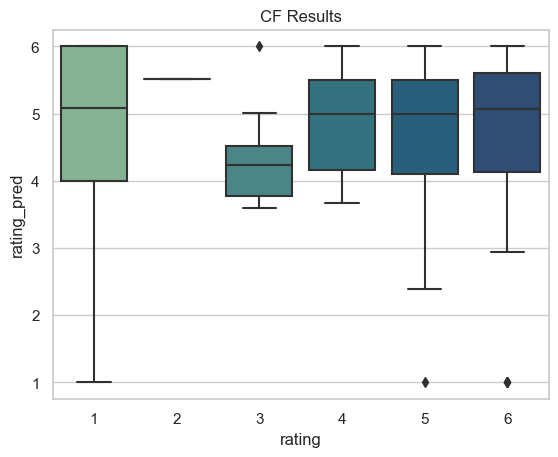

In [47]:
# Average the rating of each user on each detail across all recipes
interactions_train_w_deets = pd.read_csv("data/interactions_train_w_deets.csv")[['u', 'deets', 'rating']].drop_duplicates().reset_index(drop=True)
interactions_train_deets = interactions_train_w_deets.groupby(['deets', 'u']).mean().reset_index()
interactions_train_deets = interactions_train_deets[interactions_train_deets['deets'].str.len() > 0]

# Merge training ratings of details with testing true ratings of recipes
interactions_test_w_deets = pd.read_csv("data/interactions_test_w_deets.csv")[['u', 'i', 'deets', 'rating']].drop_duplicates().reset_index(drop=True)
pred_df = interactions_test_w_deets[['u', 'i', 'deets']].merge(interactions_train_deets[['u', 'deets', 'rating']], on=['u', 'deets'])
# Group on recipes to get average of detail ratings as predicted recipe rating
pred_df = pred_df.groupby(['u', 'i'])['rating'].mean().reset_index()
pred_df.columns = ['u', 'i', 'rating_pred']

# Merge back with testing data for evaluation
CB = interactions_test_w_deets[['u', 'i', 'rating']].merge(pred_df, how='inner', on=['i', 'u'])
CB = CB.drop_duplicates()

calculate_metrics(CB, true_total, "CB")
plot_results(CB, "CF")

## 3. Matrix Factorization for Collaborative Filtering

Below is a Non-negative matrix factorization approach (NMF) for matrix factorization that if often used for factoring sparse matrices. I based this class on the NMF class in the Surprise Python package and uses Surprise-style datasets, which have certain properties like the number of users and ratings.

In [48]:
class NMF():
    # Matrix Factorization of a sparse matrix using NMF. 
    # Fitt by perfoming SGD on the Q and P matrices defined above in the notes.
    # Loss function is MSE between the actual matrix and the product of Q and P.
    # Predict by multiplying the resulting the corresponding entries of the Q and P matrices together. 
    def __init__(self, n_factors=15, n_epochs=50, reg_pu=.06,
                 reg_qi=.06, random_state=None):
    # params:
    # n_factors: the number of latent factors to decompose matrix into (the number of rows in in P and the number of columns in Q)
    # n_epochs: the number of iterations of SGD
    # reg_pu and reg_qi: the regularization terms to apply to the SGD updates
    # random_state: optional
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.reg_pu = reg_pu
        self.reg_qi = reg_qi
        self.random_state = random_state


    def fit(self, trainset):
        # trainset: n x m matrix of ratings
        self.trainset = trainset
        self.sgd(trainset)
        return self

    def sgd(self, trainset):

        # user and item factors
        pu = np.random.uniform(0, 0.5, size=(trainset.n_users, self.n_factors))
        qi = np.random.uniform(0, 0.5, size=(trainset.n_items, self.n_factors))

        n_factors = self.n_factors
        reg_pu = self.reg_pu
        reg_qi = self.reg_qi

        # auxiliary matrices used in optimization process
        user_num = np.zeros((trainset.n_users, n_factors))
        user_denom = np.zeros((trainset.n_users, n_factors))
        item_num = np.zeros((trainset.n_items, n_factors))
        item_denom = np.zeros((trainset.n_items, n_factors))

        self.losses = []

        for current_epoch in range(self.n_epochs):

            print("Processing epoch {}".format(current_epoch))

            user_num[:, :] = 0
            user_denom[:, :] = 0
            item_num[:, :] = 0
            item_denom[:, :] = 0

            epoch_loss = 0
            l = 0
            # Compute numerators and denominators for users and items factors
            for u, i, r in trainset.all_ratings():

                # compute current estimation and error
                dot = 0  # <q_i, p_u>
                for f in range(n_factors):
                    dot += qi[i, f] * pu[u, f]
                est = dot
                err = r - est
                epoch_loss += err**2
                l += 1
                # compute numerators and denominators
                for f in range(n_factors):
                    user_num[u, f] += qi[i, f] * r
                    user_denom[u, f] += qi[i, f] * est
                    item_num[i, f] += pu[u, f] * r
                    item_denom[i, f] += pu[u, f] * est

            print(epoch_loss, l)
            epoch_loss = epoch_loss / l
            print(epoch_loss)
            self.losses.append(epoch_loss)
            # Update user factors
            for u in trainset.all_users():
                n_ratings = len(trainset.ur[u])
                for f in range(n_factors):
                    if pu[u, f] != 0:  # Can happen if user only has 0 ratings
                        user_denom[u, f] += n_ratings * reg_pu * pu[u, f]
                        pu[u, f] *= user_num[u, f] / user_denom[u, f]

            # Update item factors
            for i in trainset.all_items():
                n_ratings = len(trainset.ir[i])
                for f in range(n_factors):
                    if qi[i, f] != 0:
                        item_denom[i, f] += n_ratings * reg_qi * qi[i, f]
                        qi[i, f] *= item_num[i, f] / item_denom[i, f]

        self.pu = np.asarray(pu)
        self.qi = np.asarray(qi)

    def predict(self, u, i):
        known_user = self.trainset.knows_user(u)
        known_item = self.trainset.knows_item(i)

        if known_user and known_item:
            est = np.dot(self.qi[i], self.pu[u])
        else:
            est = None

        return est

I chose to perform the factorization into 40 latent factors because this number is a common default for recommendation packages in python. I
decided to go with this approach rather choosing this number through cross-validation because I wanted to focus my time for this project more
on exploring different algorithms rather than tuning this particular approach. I initialized the $P$ and $Q$ matrices as uniform random
matrices between 0 and 1. The shapes of these matrices are:

-   $P$: number of users by number of features (40).

-   $Q$: number of features (40) by number of recipes.

I trained the model by performing Gradient Descent for 100 iterations according to the matrix updates in the notes. Below is the training
loss across iterations and the distribution of testing predictions versus true ratings. 

![MF_loss](../viz/MF_loss.png)

Content-Augmented CF : RMSE: 1.0012067634537283 MAE: 0.6901512292252543 Coverage: 0.9995193463109829


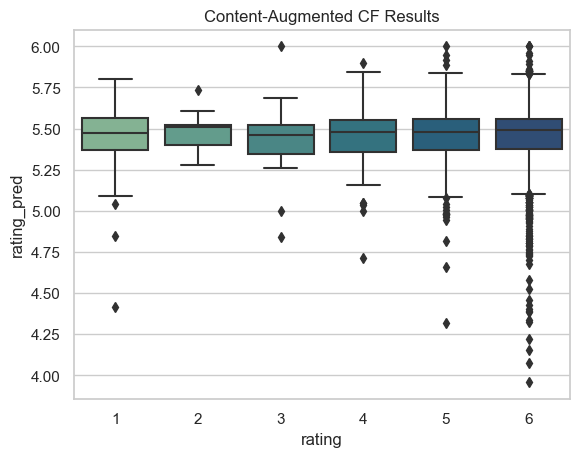

In [50]:
CA_CF = pd.read_csv("results/CA_CF.csv", index_col=0)
calculate_metrics(CA_CF, true_total, "Content-Augmented CF")
plot_results(CA_CF, "Content-Augmented CF")

# Summary of Findings

I trained each model above and then generated predictions using each user-recipe pair in the testing set. The baseline model randomly predicts ratings for user-recipe pairs by sampling from a unifrom distribution. 
|  Model                                  |  RMSE  |   MAE   |    Coverage |
|  ---------------------------------------| -------| --------| ----------|
|  Baseline                               |  2.5185|   2.04112|   1.0|
|  Vanilla CF                             |  0.9805|   0.5617|    1.0|
|  Matrix factorization CF                |  1.7859|   1.4959|    0.6837|
|  CB                                     |  1.3987|   1.0338|    0.3343|
|  Content-augmented CF                   |  1.0787|   0.8480|    0.9995|
|  Content-augmented matrix factorization |  4.1741|   3.8136|    1.1|



# References

1.  Trang Tran, T. N., Atas, M., Felfernig, A., & Stettinger, M. (2018).
    An overview of recommender systems in the healthy food domain.
    *Journal of Intelligent Information Systems*, 50 (pp. 501-526).

2.  Pecune, F., Callebert, L., & Marsella, S. (2020, September). A
    Recommender System for Healthy and Personalized Recipes
    Recommendations. In *HealthRecSys@ RecSys* (pp. 15-20).

3.  Van Pinxteren, Y., Geleijnse, G., & Kamsteeg, P. (2011, February).
    Deriving a recipe similarity measure for recommending healthful
    meals. In *Proceedings of the 16th international conference on
    Intelligent user interfaces* (pp. 105-114).

4.  Masthoff, J. (2011). Group recommender systems: Combining individual
    models. *Recommender systems handbook*, Springer (pp. 677--702).

5.  Ajitsaria, A. Build a Recommendation Enging with Collaborate
    Filtering. *RealPython.com*

6.  Freyne, J., & Berkovsky, S. (2010, February). Intelligent food
    planning: personalized recipe recommendation. In *Proceedings of the
    15th international conference on Intelligent user interfaces* (pp.
    321-324).

7.  Burke, R. (2002). Hybrid Recommender Systems: Survey and
    Experiments. *User Model User-Adap Inter* 12, (pp. 331--370).

8.  Aberg, J. (2006, January). Dealing with Malnutrition: A Meal
    Planning System for Elderly. In *AAAI spring symposium:
    argumentation for consumers of healthcare* (pp. 1-7).

9.  Luo, S. (2018, December). Introduction to Recommender System
    Approaches of Collaborative Filtering: Nearest Neighborhood and
    Matrix Factorization. *towardsdatascience.com*

10. Forbes, P., & Zhu, M. (2011, October). Content-boosted matrix
    factorization for recommender systems: experiments with recipe
    recommendation. In *Proceedings of the fifth ACM conference on
    Recommender systems* (pp. 261-264).

11. X. Luo, M. Zhou, Y. Xia and Q. Zhu. (May 2014). An Efficient
    Non-Negative Matrix-Factorization-Based Approach to Collaborative
    Filtering for Recommender Systems,\" in *IEEE Transactions on
    Industrial Informatics,* vol. 10, no. 2 (pp. 1273-1284)



<!-- # Methodology

## Data Preprocessing

For the recipe data set:

-   Ingredients will be extracted and associated with their \"base\"
    ingredient per the ingredient lemmatization map.

-   Tokenization of recipe tags.

-   Cooking techniques extracted from recipe steps.

\
For data fusion:

-   Each ingredient in each recipe queried for flavor profile.

-   Flavor profile of each ingredient aggregated across recipe.

-   Flavor profile associated with respective recipe.

\
Train-test split:

-   For interactions data set, data will be split into training,
    evaluation, and testing data sets. The interactions data will be the
    source of ground-truth that I will use to evaluate the
    recommendations. All/any recipes could be present in each of the
    train, eval, and test interactions data sets. -->

<!-- # Methodology

## Data Preprocessing

For the recipe data set:

-   Ingredients will be extracted and associated with their \"base\"
    ingredient per the ingredient lemmatization map.

-   Tokenization of recipe tags.

-   Cooking techniques extracted from recipe steps.

\
For data fusion:

-   Each ingredient in each recipe queried for flavor profile.

-   Flavor profile of each ingredient aggregated across recipe.

-   Flavor profile associated with respective recipe.

\
Train-test split:

-   For interactions data set, data will be split into training,
    evaluation, and testing data sets. The interactions data will be the
    source of ground-truth that I will use to evaluate the
    recommendations. All/any recipes could be present in each of the
    train, eval, and test interactions data sets. -->

<!-- # Methodology

## Data Preprocessing

For the recipe data set:

-   Ingredients will be extracted and associated with their \"base\"
    ingredient per the ingredient lemmatization map.

-   Tokenization of recipe tags.

-   Cooking techniques extracted from recipe steps.

\
For data fusion:

-   Each ingredient in each recipe queried for flavor profile.

-   Flavor profile of each ingredient aggregated across recipe.

-   Flavor profile associated with respective recipe.

\
Train-test split:

-   For interactions data set, data will be split into training,
    evaluation, and testing data sets. The interactions data will be the
    source of ground-truth that I will use to evaluate the
    recommendations. All/any recipes could be present in each of the
    train, eval, and test interactions data sets. -->